In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy
import scipy.io
import soundpy as sp
import sounddevice

speech_data = scipy.io.loadmat('project1.mat')
fs = speech_data['fs'][0]
speech_desired = speech_data['reference'][0]
speech_noisy = speech_data['primary'][0]

# Normalization
# wav = wav / np.sqrt(np.sum(wav ** 2))

In [2]:
sounddevice.play(speech_data['primary'][0], fs)

In [3]:
sounddevice.play(speech_data['reference'][0], fs)

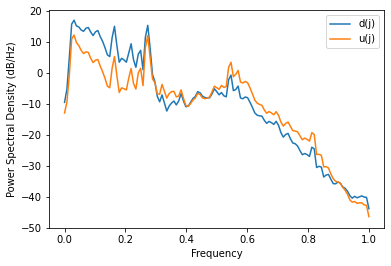

In [2]:
l1 = plt.psd(speech_desired)
l2 = plt.psd(speech_noisy)
plt.legend(['d(j)','u(j)'])
plt.grid(False)

In [5]:
# Plot Performance Surface Contour

num_weight = 50
w1 = np.linspace(0, 2, num_weight)
w2 = np.linspace(0, 2, num_weight)
weight_w1, weight_w2 = np.meshgrid(w1, w2)
error_surface = np.zeros((num_weight, num_weight))
for i in range (num_weight):
    for j in range (num_weight):
        error_array = [speech_desired[k] - np.dot(np.array([weight_w1[i][j], weight_w2[i][j]]), speech_noisy[k-1:k+1]) for k in range (1, len(speech_noisy))]
        error_surface[i, j] = np.sqrt(np.sum(np.array(error_array) ** 2)/np.sum(speech_desired ** 2))
        

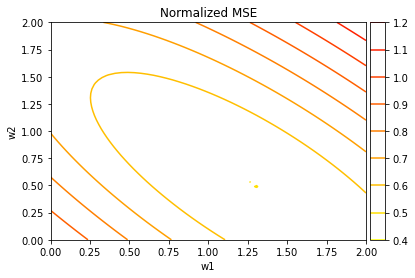

In [6]:
# plot 2D contour

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.gca()
cf = ax.contour(weight_w1, weight_w2, error_surface, cmap = 'autumn_r') # contour, plt draw, scale, optimization
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Normalized MSE')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)
plt.show()

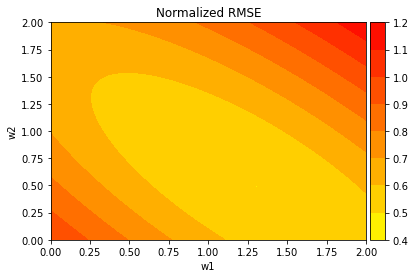

In [7]:
# plot 2D contourf

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
ax = fig.gca()
cf = ax.contourf(weight_w1, weight_w2, error_surface, cmap = 'autumn_r') # contour, plt draw, scale, optimization
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_title('Normalized RMSE')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax)
plt.show()

In [16]:
# NLMS Algorithm, start (n-order:n, n-order+1:n+1)

filter_order = 2

weight_filter = np.zeros((filter_order))

step_size = 0.003 # step_size

weight_store = []
error_store = []

for n in range (filter_order-1, speech_desired.shape[0]):
    e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
    weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
    weight_store.append(weight_filter)
    y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
    error_store.append(y_error)
    
weight_store = np.array(weight_store)
error_store = np.array(error_store)


# Calculate ERLE
ERLE = 10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2))
ERLE

5.919046091596153

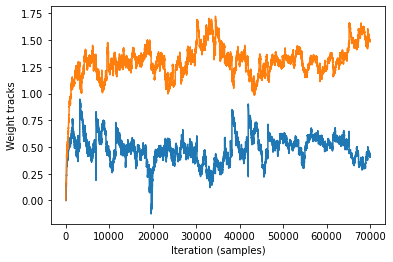

In [17]:
# weight filter_order = 2
plt.plot(np.arange(len(weight_store)), weight_store)
plt.xlabel('Iteration (samples)')
plt.ylabel('Weight tracks')
plt.show()

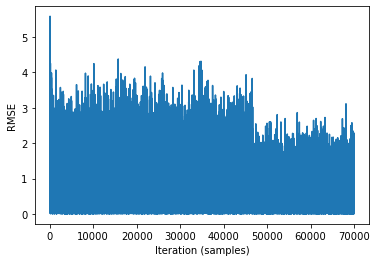

Mean of Error 0.8125531990283799
Std of Error 0.638579189220769


In [18]:
# error filter_order = 2
plt.plot(np.arange(len(error_store)), abs(error_store))
plt.xlabel('Iteration (samples)')
plt.ylabel('RMSE')
plt.show()
print('Mean of Error', np.mean(abs(error_store)))
print('Std of Error', np.std(abs(error_store)))

In [11]:
# Frequency response
expected_signal = [np.dot(weight_store[-1], speech_noisy[n-filter_order+1:n+1][::-1]) for n in range(filter_order-1, speech_desired.shape[0])]
freq_response_desired_signal = speech_desired[filter_order-1:speech_desired.shape[0]]
freq_response_error = freq_response_desired_signal - expected_signal

In [12]:
weight_store[-1]

array([0.41700815, 1.49109725])

Text(0, 0.5, 'Response Amplitude')

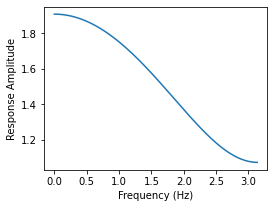

In [13]:
import scipy.signal
NumeratorZcoefs = weight_store[-1]
DenominatorZcoefs = [1]
FreqResponse = scipy.signal.freqz(NumeratorZcoefs, DenominatorZcoefs)
fig = plt.figure(figsize = [4, 3])
ax = fig.add_subplot(111)
ax.plot(FreqResponse[0], abs(np.array(FreqResponse[1])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response Amplitude')

In [19]:
# NLMS Algorithm, start (n-order:n, n-order+1:n+1)

filter_order = 10

weight_filter = np.zeros((filter_order))

step_size = 0.05 # step_size

weight_store = []
error_store = []

for n in range (filter_order-1, speech_desired.shape[0]):
    e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
    weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
    weight_store.append(weight_filter)
    y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
    error_store.append(y_error)
    
weight_store = np.array(weight_store)
error_store = np.array(error_store)


# Calculate ERLE
ERLE = 10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2))
ERLE

18.949848292192556

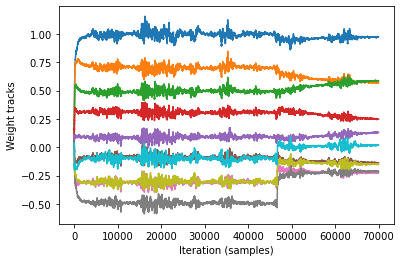

In [20]:
# weight
plt.plot(np.arange(len(weight_store)), weight_store)
plt.xlabel('Iteration (samples)')
plt.ylabel('Weight tracks')
plt.show()

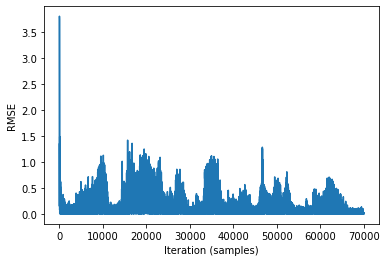

Mean of Error 0.15005888147253676
Std of Error 0.17501195732700547


In [21]:
# error
plt.plot(np.arange(len(error_store)), abs(error_store))
plt.xlabel('Iteration (samples)')
plt.ylabel('RMSE')
plt.show()
print('Mean of Error', np.mean(abs(error_store)))
print('Std of Error', np.std(abs(error_store)))

Text(0, 0.5, 'Response Amplitude')

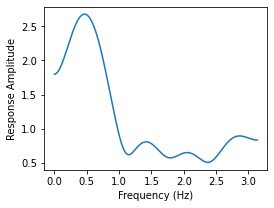

In [17]:
# Frequency Response
import scipy.signal
NumeratorZcoefs = weight_store[-1]
DenominatorZcoefs = [1]
FreqResponse = scipy.signal.freqz(NumeratorZcoefs, DenominatorZcoefs)
fig = plt.figure(figsize = [4, 3])
ax = fig.add_subplot(111)
ax.plot(FreqResponse[0], abs(np.array(FreqResponse[1])))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Response Amplitude')

In [18]:
# The filter performance as a function of step size

filter_order = 10

stepsize_array = np.logspace(-4, 1, 30)

ERROR_store = []
ERLE_store = []
WEIGHT_store = []

for step_size in stepsize_array: # step_size

    error_store = []
    weight_filter = np.zeros((filter_order))

    for n in range (filter_order-1, speech_desired.shape[0]):
        e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
        weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
        y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
        error_store.append(y_error)
        
    error_store = np.array(error_store)
    ERROR_store.append(np.sqrt(np.sum(error_store ** 2)/np.sum(speech_desired ** 2)))
    ERLE_store.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2)))
    WEIGHT_store.append(weight_filter)


C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_23100/532826991.py:18: RuntimeWarning: overflow encountered in multiply
  weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_23100/532826991.py:18: RuntimeWarning: invalid value encountered in add
  weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_23100/532826991.py:23: RuntimeWarning: overflow encountered in square
  ERROR_store.append(np.sqrt(np.sum(error_store ** 2)/np.sum(speech_desired ** 2)))
D:\Software\Anaconda\Install\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\KAIFAL~1\AppData\Local\Temp/ipykernel_23100/53282

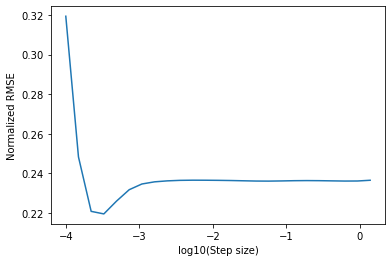

In [19]:
ERROR_opt_weight = []
ERLE_opt_weight = []
for i in range(len(stepsize_array)):
    error_opt_weight = []
    for n in range (filter_order-1, speech_desired.shape[0]):
        error_opt_weight.append(speech_desired[n] - np.dot(WEIGHT_store[i], speech_noisy[n-filter_order+1:n+1][::-1]))
    error_opt_weight = np.array(error_opt_weight)
    ERROR_opt_weight.append(np.sqrt(np.sum(error_opt_weight ** 2)/np.sum(speech_desired ** 2)))
    ERLE_opt_weight.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_opt_weight ** 2)))
    
# Plot ERROR by stepsize
for i in range (len(stepsize_array)):
    stepsize_array[i] = math.log10(stepsize_array[i])
plt.plot(stepsize_array, ERROR_opt_weight) # ERROR_opt_weight, ERROR_store
plt.xlabel('log10(Step size)')
#plt.xlim([0, 0.01])
plt.ylabel('Normalized RMSE')
plt.show()

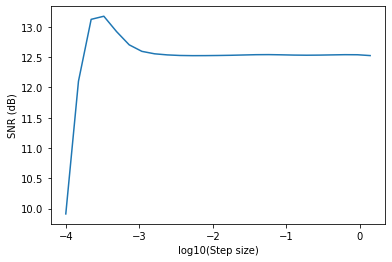

In [20]:
# Plot ERLE by stepsize
plt.plot(stepsize_array, ERLE_opt_weight) # ERLE_opt_weight, ERLE_store
plt.xlabel('log10(Step size)')
plt.ylabel('SNR (dB)')
plt.show()

In [21]:
# Calculate Misadjustment under different initialization conditions

filter_order = 10
step_size = 0.005

WEIGHT_store = []
ERROR_store = []
ERLE_store = []
WEIGHT_OPT = []

for i in range(20): # step_size
    
    weight_filter = np.random.normal(0, 0.1, filter_order)
    WEIGHT_store.append(weight_filter)
    error_store = []

    for n in range (filter_order-1, speech_desired.shape[0]):
        e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
        weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
        y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
        error_store.append(y_error)
        
    error_store = np.array(error_store)
    ERROR_store.append(np.sum(error_store ** 2)/np.sum(speech_desired ** 2))
    ERLE_store.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2)))
    WEIGHT_OPT.append(weight_filter)


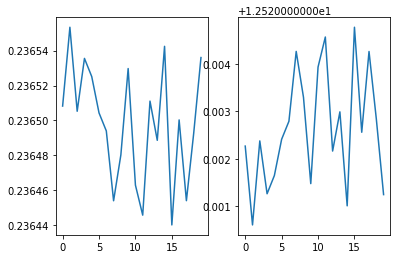

Error_Mean: 0.2364981781151112
Error_SD: 3.289602793909263e-05
ERLE_Mean: 12.522634420537548
ERLE_SD: 0.001208192709538335


In [22]:
ERROR_opt_weight = []
ERLE_opt_weight = []
for i in range(20):
    error_opt_weight = []
    for n in range (filter_order-1, speech_desired.shape[0]):
        error_opt_weight.append(speech_desired[n] - np.dot(WEIGHT_OPT[i], speech_noisy[n-filter_order+1:n+1][::-1]))
    error_opt_weight = np.array(error_opt_weight)
    ERROR_opt_weight.append(np.sqrt(np.sum(error_opt_weight ** 2)/np.sum(speech_desired ** 2)))
    ERLE_opt_weight.append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_opt_weight ** 2)))
    
# Plot misadjustment
ax1 = plt.subplot(1,2,1)
ax1.plot(ERROR_opt_weight)
ax2 = plt.subplot(1,2,2)
ax2.plot(ERLE_opt_weight)
plt.show()
print('Error_Mean:', np.mean(np.array(ERROR_opt_weight)))
print('Error_SD:', np.std(np.array(ERROR_opt_weight)))
print('ERLE_Mean:', np.mean(np.array(ERLE_opt_weight)))
print('ERLE_SD:', np.std(np.array(ERLE_opt_weight)))

In [23]:
# Calculate Misadjustment, under different filter orders (2-11)

step_size = 0.005

WEIGHT_store = []
ERROR_store = []
ERLE_store = []
WEIGHT_OPT = []
ERROR_mean_sd = []
ERLE_mean_sd = []
ERROR_opt_weight = []
ERLE_opt_weight = []

for mm in range (10):
    filter_order = mm + 2
    WEIGHT_store.append([])
    ERROR_store.append([])
    ERLE_store.append([])
    WEIGHT_OPT.append([])
    ERROR_opt_weight.append([])
    ERLE_opt_weight.append([])
    
    for i in range(20):

        weight_filter = np.random.normal(0, 0.1, filter_order)
        WEIGHT_store[mm].append(weight_filter)
        error_store = []

        for n in range (filter_order-1, speech_desired.shape[0]):
            e_n = speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])
            weight_filter = weight_filter + step_size * speech_noisy[n-filter_order+1:n+1][::-1] * e_n / (np.linalg.norm(speech_noisy[n-filter_order+1:n+1]) ** 2 + 1e-5)
            y_error = np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1])-speech_desired[n]
            error_store.append(y_error)

        error_store = np.array(error_store)
        ERROR_store[mm].append(np.sum(error_store ** 2)/np.sum(speech_desired ** 2))
        ERLE_store[mm].append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_store ** 2)))
        WEIGHT_OPT[mm].append(weight_filter)
        
        # use the optimal weight to calculate error
        error_opt_weight = []
        for n in range (filter_order-1, speech_desired.shape[0]):
            error_opt_weight.append(speech_desired[n] - np.dot(weight_filter, speech_noisy[n-filter_order+1:n+1][::-1]))
        error_opt_weight = np.array(error_opt_weight)
        ERROR_opt_weight[mm].append(np.sqrt(np.sum(error_opt_weight ** 2)/np.sum(speech_desired ** 2)))
        ERLE_opt_weight[mm].append(10 * math.log10(np.sum(speech_desired[filter_order-1:speech_desired.shape[0]] ** 2) / np.sum(error_opt_weight ** 2)))
    
    ERROR_mean_sd.append([np.mean(ERROR_opt_weight[mm]), np.std(ERROR_opt_weight[mm])])
    ERLE_mean_sd.append([np.mean(ERLE_opt_weight[mm]), np.std(ERLE_opt_weight[mm])])


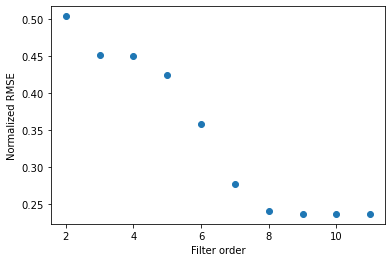

In [24]:
# Plot Errorbar Normalized Error
order_filter_array = np.arange(2,12)
plt.errorbar(order_filter_array, np.array(ERROR_mean_sd)[:, 0], yerr = np.array(ERROR_mean_sd)[:, 1], fmt ='o')
plt.xlabel('Filter order')
plt.ylabel('Normalized RMSE')
plt.show()

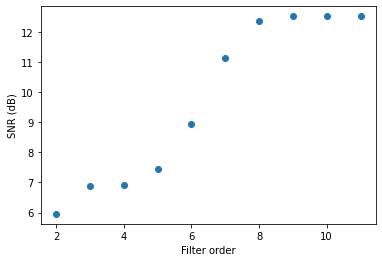

In [25]:
# Plot Errorbar ERLE
order_filter_array = np.arange(2,12)
plt.errorbar(order_filter_array, np.array(ERLE_mean_sd)[:, 0], yerr = np.array(ERLE_mean_sd)[:, 1], fmt ='o')
plt.xlabel('Filter order')
plt.ylabel('SNR (dB)')
plt.show()